# Get Setup

In [1]:
# we need torch 1.12+ and torchvision 0.13+
%load_ext autoreload
%autoreload 2
try:
    print("OK")
    import torch
    import torchvision

    assert float(torch.__version__.split(".")[0]) > 1 or int(
        torch.__version__.split(".")[1]) > 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio -- extra-index-url https: // download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

OK
torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# try to get torchinfo, if doesn't exist, install it
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

# try to import the going_modular directory, download it from github if it doesn't exist
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    raise FileNotFoundError

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [4]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# creat dataloaders

In [6]:
from going_modular import data_setup
from torchvision import transforms

# creat image size (224,224)
IMG_SIZE = 224  # comes from table 3 of the ViT paper

# create transforms
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"manually created transforms: {manual_transforms}")

manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# create batch size 32, the paper used 4096.
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=0)

len(train_dataloader), len(test_dataloader), class_names  # (32, 32, 3a)

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# get batch images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

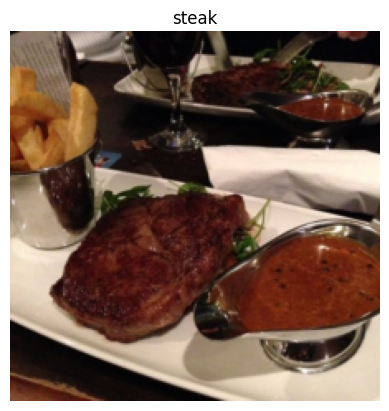

In [9]:
# plot image

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
height = 224
width = 224
color_chanel = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size ** 2)
embedding_layer_input_shape = (height, width, color_chanel)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_chanel)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

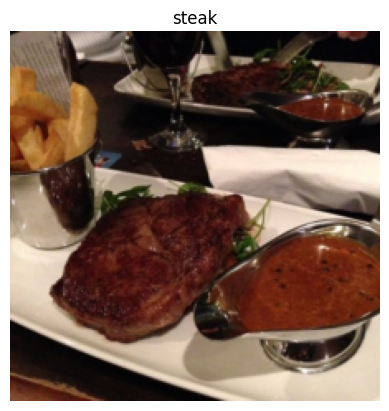

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

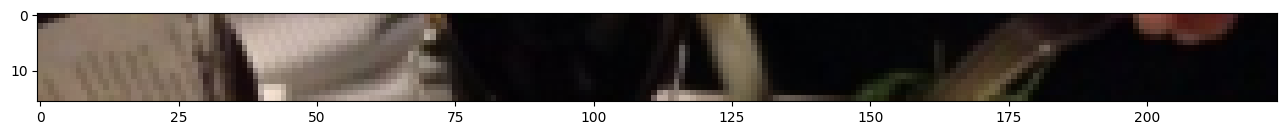

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

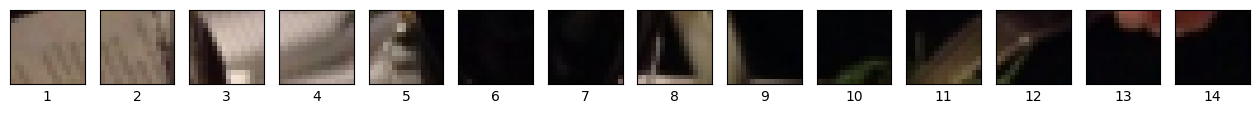

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "image should be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

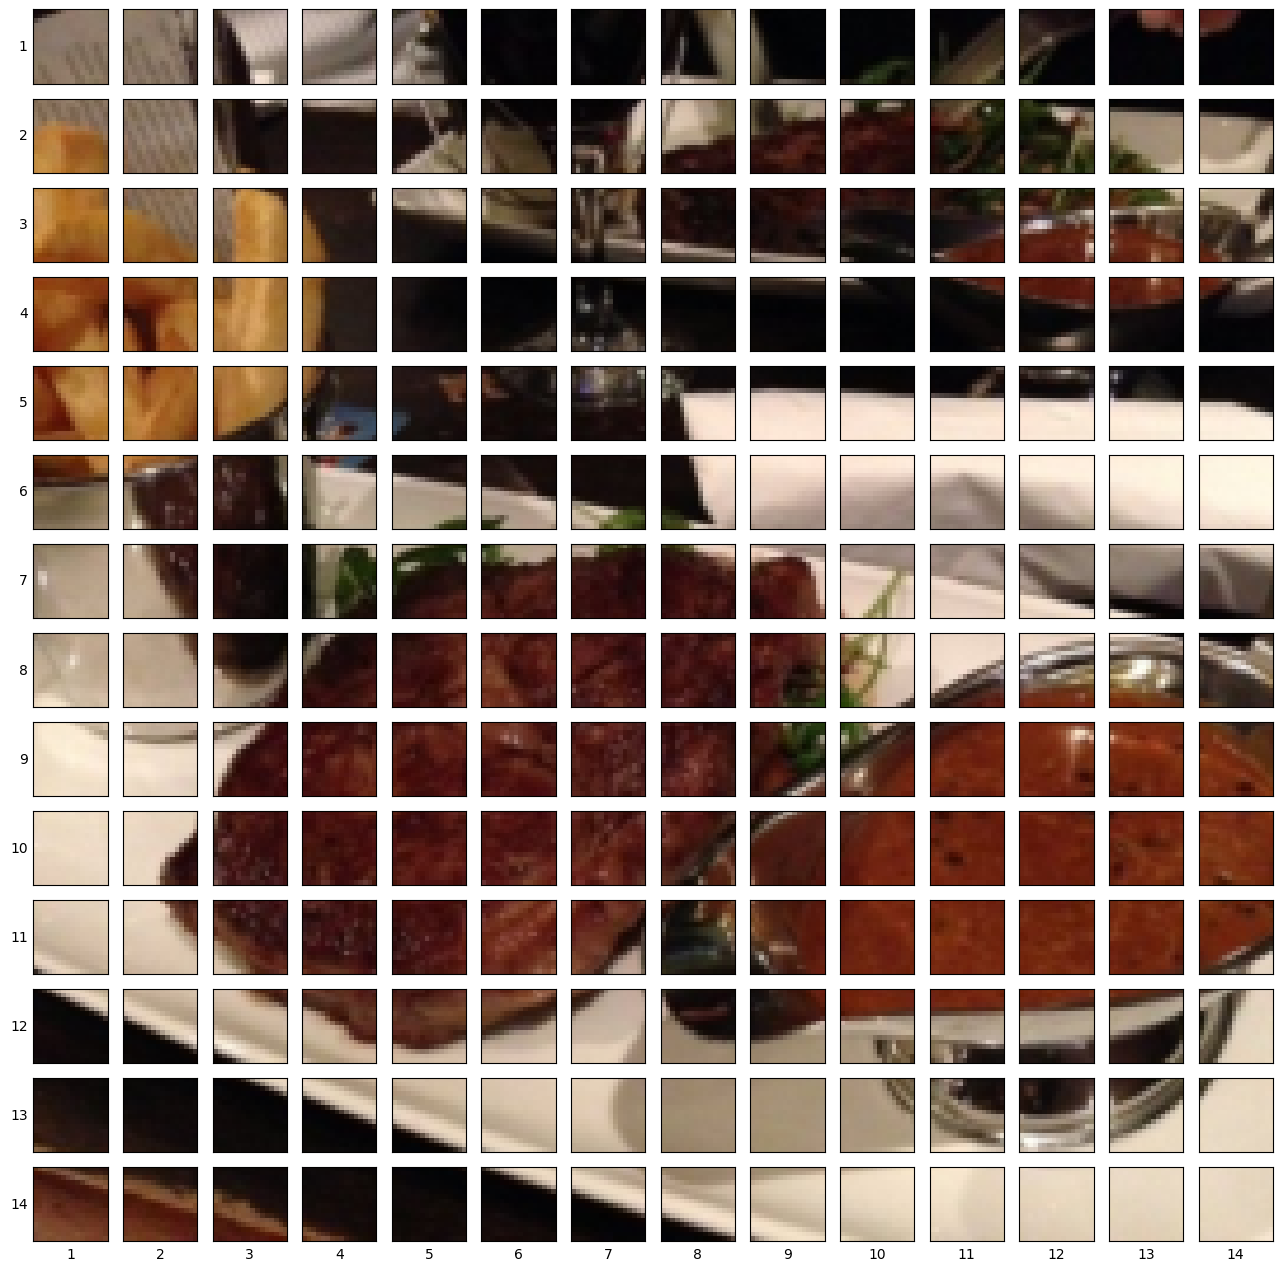

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "image should be divisible by patch size"

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size,
                         patch_width:patch_width + patch_size, :])
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_ylabel(i + 1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center"
                             )
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


In [15]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, padding=0, stride=patch_size)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

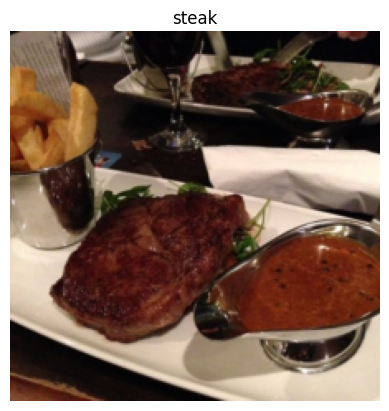

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [26]:
# pass the image
image_out_of_conv = conv2d(image.unsqueeze(0)) #  add batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [29]:
image_out_of_conv.requires_grad

True

showing random convolutional features maps from indexes: [465, 329, 381, 47, 428]


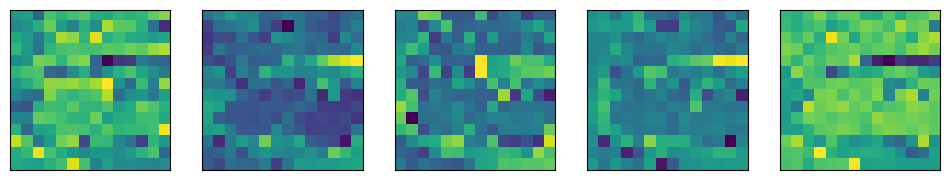

In [32]:
import random
random_indexes = random.sample(range(0,758), k=5)
print(f"showing random convolutional features maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]  #  index on the output axis
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [33]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [34]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

In [35]:
image_out_of_flatten = flatten_layer(image_out_of_conv)
print(image_out_of_flatten.shape)

torch.Size([1, 768, 196])


original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shapetorch.Size([1, 768, 196])


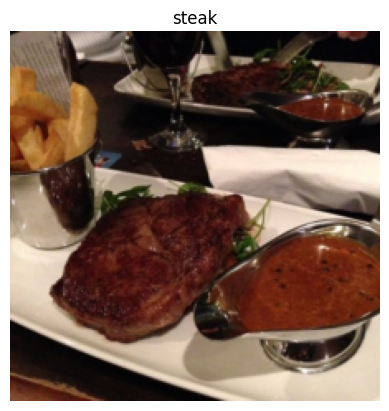

In [39]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape{image_out_of_conv_flattened.shape}")

In [42]:
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)
